In [84]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets # torchvision containe predefined datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np



In [85]:
# get training data

#torchvision.datasets.FashionMNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
'''
root (string) – Root directory of dataset where FashionMNIST/raw/train-images-idx3-ubyte and FashionMNIST/raw/t10k-images-idx3-ubyte exist.

train (bool, optional) – If True, creates dataset from train-images-idx3-ubyte, otherwise from t10k-images-idx3-ubyte.

download (bool, optional) – If True, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop

target_transform (callable, optional) – A function/transform that takes in the target and transforms it.

'''
training_data = datasets.FashionMNIST(root="data", train=True,
                                      download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False,
                                      download=True, transform=ToTensor())

In [86]:
# https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#FashionMNIST
# get class names and convert it into a dict

classes = datasets.FashionMNIST.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


T-shirt/top


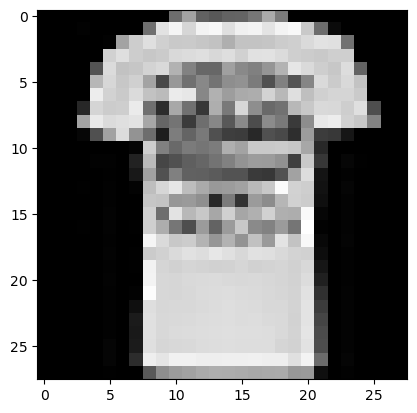

In [87]:
img,label = training_data[np.random.randint(low=0, high=len(training_data))]
print( classes[label])
plt.imshow(img.squeeze(), cmap="gray")


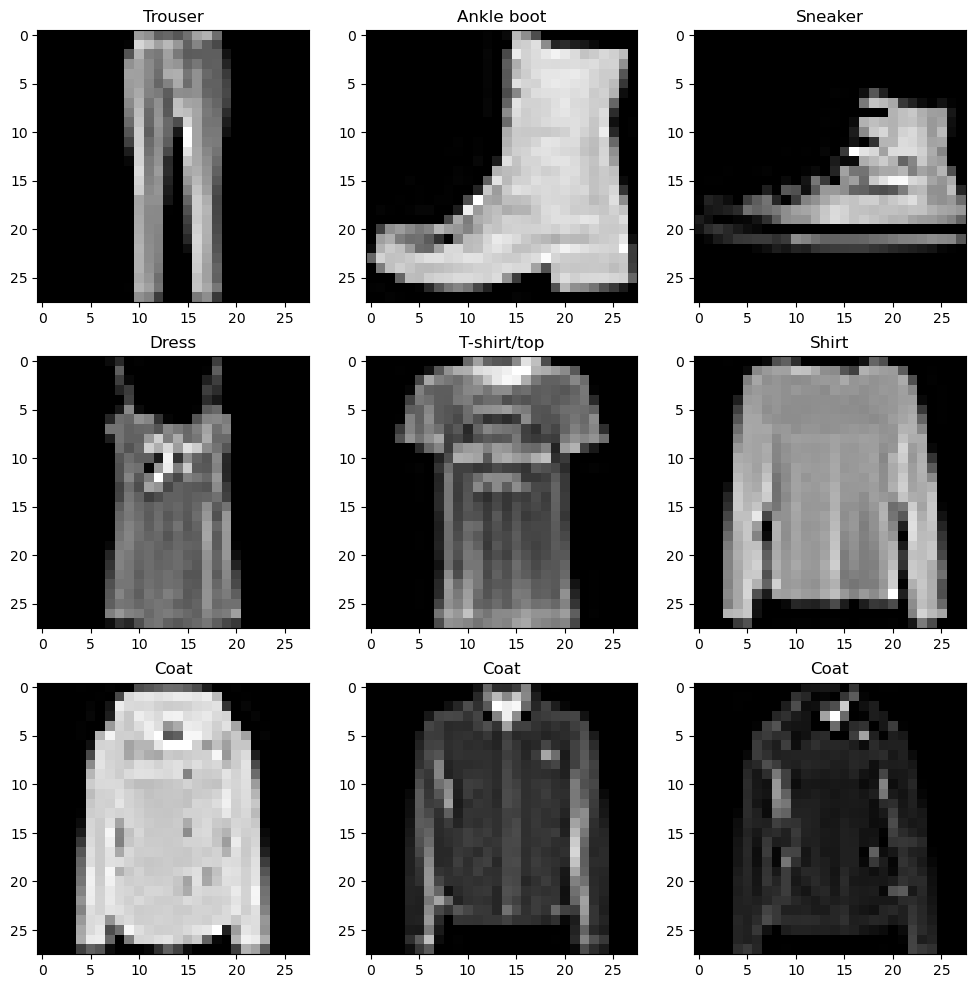

In [88]:
# show some more examples of the data
figure = plt.figure(figsize=(12,12))
# show 9 examples
rows = columns = 3
for i in range(rows* columns):
    img, label = training_data[np.random.randint(low=0, high=len(training_data))]
    figure.add_subplot(rows, columns, i +1)
    plt.title(classes[label])
    plt.imshow(img.squeeze(),cmap="gray")
plt.show()

In [89]:
# to select a batch size from thre data to train we can use dataloader
'''
dataset (Dataset) – dataset from which to load the data.

batch_size (int, optional) – how many samples per batch to load (default: 1).

shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

sampler (Sampler or Iterable, optional) – defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented. If specified, shuffle must not be specified.

batch_sampler (Sampler or Iterable, optional) – like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.

num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

collate_fn (callable, optional) – merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.

pin_memory (bool, optional) – If True, the data loader will copy Tensors into CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

timeout (numeric, optional) – if positive, the timeout value for collecting a batch from workers. Should always be non-negative. (default: 0)

worker_init_fn (callable, optional) – If not None, this will be called on each worker subprocess with the worker id (an int in [0, num_workers - 1]) as input, after seeding and before data loading. (default: None)

generator (torch.Generator, optional) – If not None, this RNG will be used by RandomSampler to generate random indexes and multiprocessing to generate base_seed for workers. (default: None)

prefetch_factor (int, optional, keyword-only arg) – Number of samples loaded in advance by each worker. 2 means there will be a total of 2 * num_workers samples prefetched across all workers. (default: 2)

persistent_workers (bool, optional) – If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the workers Dataset instances alive. (default: False)
'''

train_data = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [90]:
#each iteration of the dataloader will give a batch of data
trainingBatchImgs, trainingBatchLabels = next(iter(train_data))
print(trainingBatchImgs.shape, trainingBatchLabels.shape)
# now this can be passed to the network to generate labels


torch.Size([64, 1, 28, 28]) torch.Size([64])


torch.Size([1, 28, 28])
torch.Size([28, 28])
Trouser


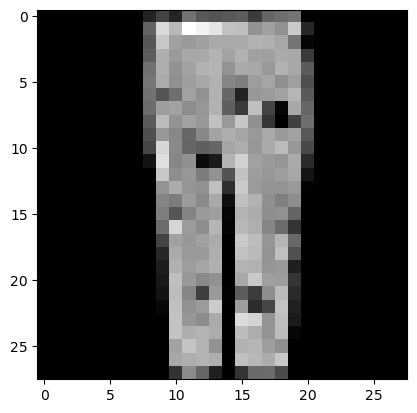

In [91]:
#
img = trainingBatchImgs[10] # take an image from the batch
print(img.shape)
print(img.squeeze().shape)
print(classes[trainingBatchLabels[10]])
plt.imshow(img.squeeze(),cmap="gray")


In [92]:
# create models

import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() 
        # group the nn together
        self.linear_relu_stack = nn.Sequential( # create sequential layers
            nn.Linear(28*28, 512), # linear layer
            nn.ReLU(),  # relu activation
            nn.Linear(512, 512), # linear layer with input size of last layer,
            nn.ReLU(),           # relu activation
            nn.Linear(512, 10)   # linear layer tht input size of last layer and o/p of size number of classes
        )

    def forward(self, x):
        x = self.flatten(x) # changel the dimension of the image
        logits = self.linear_relu_stack(x) # pass the input to the network
        return logits  # return the results

model = NeuralNetwork().to(device)  # load the model in gpu
print(model)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [103]:
# create optimization function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-01)

#
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [104]:
# def training function 
def train(dataloader, model, loss_fn, optimizer): 
    size = len(dataloader.dataset) # size of the data
    model.train()  # set model to train meaning it has the grad 
    for batch, (X, y) in enumerate(dataloader): # enumerate throught the batch
        X, y = X.to(device), y.to(device) # tranfer the model to the device

        # Compute prediction error
        pred = model(X)  # pass the inputs to the model get the prefiction
        
#         print(f"  pred : {pred[0]},\n label : {y[0]}")
        
        loss = loss_fn(pred, y) # calculate the loss between the input prediction and required output
        print(loss.item())
        # Backpropagation
        optimizer.zero_grad()  # reset the optimzer
        loss.backward()  # backpropagate the losses
        optimizer.step()  # step the optimizer

        if batch % 100 == 0:  #  calculate the batch loss checking the training performance
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [105]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [106]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
0.21424971520900726
loss: 0.214250  [    0/60000]
0.28656163811683655
0.2954886257648468
0.4015529751777649
0.3045481741428375
0.2577567994594574
0.3316812515258789
0.38091328740119934
0.2984207570552826
0.20341160893440247
0.3396773934364319
0.19139495491981506
0.24719004333019257
0.3672334551811218
0.18527373671531677
0.13725945353507996
0.2706983983516693
0.3130332827568054
0.3084567189216614
0.18662962317466736
0.27655377984046936
0.5480084419250488
0.36074379086494446
0.22138036787509918
0.16876906156539917
0.3936653733253479
0.28278687596321106
0.3192751109600067
0.23840424418449402
0.29912662506103516
0.24246898293495178
0.41679003834724426
0.3177805542945862
0.31537818908691406
0.43492379784584045
0.2962585687637329
0.26112520694732666
0.30480122566223145
0.2550601065158844
0.2958963215351105
0.3410070538520813
0.23788383603096008
0.14382484555244446
0.27434810996055603
0.2587132453918457
0.2844492197036743
0.3110659122467041
0.4822404384

0.37049397826194763
0.19696708023548126
0.42357197403907776
0.3739488422870636
0.23380890488624573
0.31464138627052307
0.15157641470432281
0.21613635122776031
0.29446524381637573
0.41238701343536377
0.39584627747535706
0.3469928503036499
0.2550405263900757
0.2513889670372009
0.42066246271133423
0.3288959860801697
0.28924959897994995
0.33466508984565735
0.38534051179885864
0.42459896206855774
0.24721406400203705
0.22509104013442993
0.38777461647987366
0.2833995819091797
0.2735925614833832
0.3146648705005646
0.48464956879615784
0.21334585547447205
0.25835365056991577
0.2365087866783142
0.26154613494873047
0.248043492436409
0.26510536670684814
0.17895230650901794
0.25543951988220215
0.2708016633987427
0.4277217984199524
0.29276028275489807
0.30925023555755615
0.29378536343574524
0.2470855712890625
0.31572890281677246
0.4512491524219513
0.3247726559638977
0.3113333284854889
0.27601900696754456
0.3512091338634491
0.3187757730484009
0.3235004246234894
0.23437508940696716
0.3086238205432892
l

0.18551310896873474
0.20894652605056763
0.3105197250843048
0.3030437231063843
0.34254688024520874
0.28237444162368774
0.24604082107543945
0.2845114469528198
0.2626221179962158
0.2766132354736328
0.31548887491226196
0.20718421041965485
0.19930101931095123
0.15012909471988678
0.22561194002628326
0.2087123990058899
0.30760422348976135
0.4419877529144287
0.35910817980766296
0.3179081976413727
0.3354976773262024
0.3342170715332031
0.2882576882839203
0.21721896529197693
0.2875463366508484
loss: 0.287546  [57600/60000]
0.3861132860183716
0.3097786605358124
0.4777773320674896
0.35507720708847046
0.2310253530740738
0.2511250972747803
0.30101004242897034
0.31775546073913574
0.26757919788360596
0.32236528396606445
0.3045922815799713
0.27968448400497437
0.27918604016304016
0.42485371232032776
0.3765701949596405
0.22588752210140228
0.4414907693862915
0.37373241782188416
0.2881218492984772
0.2505236268043518
0.36312833428382874
0.3948858082294464
0.2003602683544159
0.23393946886062622
0.349362045526

0.1972113847732544
0.2793498933315277
0.30251240730285645
0.3426322042942047
0.37360042333602905
0.19629451632499695
0.2365221381187439
0.1745232790708542
0.20262207090854645
0.27498698234558105
0.48061755299568176
0.3529343605041504
0.2190471589565277
0.24547602236270905
0.26460719108581543
0.2764315903186798
0.230783149600029
0.22480811178684235
0.20829413831233978
0.2370835244655609
0.38300031423568726
0.3098633885383606
0.25998517870903015
loss: 0.259985  [25600/60000]
0.32772308588027954
0.296568363904953
0.4496915340423584
0.3991102874279022
0.4061189293861389
0.17442254722118378
0.23247307538986206
0.34101760387420654
0.3318752348423004
0.2737922966480255
0.2995406687259674
0.26009446382522583
0.28194308280944824
0.3475073575973511
0.28453272581100464
0.3258465826511383
0.383083313703537
0.403236448764801
0.23719601333141327
0.3318292796611786
0.18113383650779724
0.21205981075763702
0.38117292523384094
0.21301694214344025
0.12777870893478394
0.2935989499092102
0.2512724399566650

0.17021769285202026
0.2715538442134857
0.3715556859970093
0.29957151412963867
0.2503228783607483
0.31980687379837036
0.32015907764434814
0.2047622948884964
0.2563948929309845
0.21782396733760834
0.24429012835025787
0.37057456374168396
0.2925953269004822
0.2774493098258972
0.3632497489452362
0.35743600130081177
0.2187895029783249
0.31796252727508545
0.23909476399421692
0.12015504390001297
0.12716397643089294
0.1063457578420639
0.34121304750442505
0.40454035997390747
0.2230525016784668
0.318659245967865
0.30097365379333496
0.25701674818992615
0.25219017267227173
0.19508670270442963
0.345909982919693
0.2724001705646515
0.2483237087726593
0.3732217848300934
0.2724851965904236
0.25545573234558105
0.42156869173049927
0.3683159351348877
0.26522427797317505
0.28271692991256714
0.2742561399936676
0.28341805934906006
0.23176482319831848
0.2806010842323303
0.432058185338974
0.27047842741012573
0.46695026755332947
0.22338184714317322
0.3936695158481598
0.3746154010295868
0.25858840346336365
0.3536

0.3335835337638855
0.27841806411743164
0.2579074501991272
0.16013304889202118
0.1341923326253891
0.1647358536720276
0.28832295536994934
0.3580431342124939
0.2686765193939209
loss: 0.268677  [19200/60000]
0.16045032441616058
0.3036232888698578
0.30640649795532227
0.4246908724308014
0.27503904700279236
0.21160782873630524
0.21000637114048004
0.23407386243343353
0.1209053248167038
0.15688616037368774
0.22336147725582123
0.1935323029756546
0.3768713176250458
0.22814972698688507
0.5692861080169678
0.33994314074516296
0.2969660758972168
0.308370977640152
0.4145205616950989
0.5666574835777283
0.28576675057411194
0.28730472922325134
0.24875502288341522
0.15638548135757446
0.3165370523929596
0.2905047535896301
0.21831871569156647
0.22775229811668396
0.21359090507030487
0.23550845682621002
0.3785528838634491
0.2351873219013214
0.5518398284912109
0.2814573645591736
0.3623924255371094
0.3164442181587219
0.16260437667369843
0.27150219678878784
0.2337813824415207
0.29990315437316895
0.36488583683967

0.3326805531978607
0.3568747639656067
0.2530413568019867
0.22617453336715698
0.27393195033073425
0.2569650113582611
0.22969813644886017
0.3085053861141205
0.3313659131526947
0.17601458728313446
0.4309238791465759
0.34554505348205566
0.17668753862380981
0.20685014128684998
0.1474265456199646
0.32466867566108704
0.2406373918056488
0.1432565152645111
0.1761101931333542
0.33339953422546387
0.13702447712421417
0.1775858849287033
0.29693567752838135
0.4665329158306122
0.287751168012619
0.319125771522522
0.282306045293808
0.23181870579719543
0.18124058842658997
0.1393287181854248
0.22465580701828003
0.3219881057739258
0.19329270720481873
0.13519315421581268
0.20078670978546143
0.19721835851669312
0.4466705322265625
0.25586798787117004
0.2996635437011719
0.1983458399772644
0.3476885259151459
0.44573503732681274
0.36551177501678467
0.25807565450668335
0.35416409373283386
0.2365935891866684
0.33544445037841797
0.2922477126121521
0.27918708324432373
0.3215716481208801
0.19707024097442627
0.211229

0.2528153955936432
0.3610171973705292
0.16077181696891785
0.2672635614871979
0.27368801832199097
0.1959352046251297
0.2862655818462372
0.2508099675178528
0.2532931864261627
0.2616058886051178
0.2509162724018097
0.4094405770301819
0.11891542375087738
0.1681264191865921
0.29796913266181946
0.26268482208251953
0.2637728452682495
0.2385893613100052
0.16408507525920868
0.4390818178653717
0.35640019178390503
0.2885778546333313
0.2874702513217926
0.30513712763786316
0.11742397397756577
0.2888742685317993
0.1908610612154007
0.18426567316055298
0.25493666529655457
0.24046625196933746
0.2138940393924713
0.25960779190063477
0.11700624972581863
0.2717677354812622
0.254873126745224
0.3793325126171112
0.23574337363243103
0.1981654018163681
0.23572584986686707
0.20026655495166779
0.21281397342681885
0.42043712735176086
0.4636748135089874
0.20342567563056946
0.2158108800649643
0.20306317508220673
0.15598700940608978
0.21895921230316162
0.4079817533493042
0.25847992300987244
0.31766238808631897
0.23124

0.21017664670944214
0.2830689251422882
0.2756781280040741
0.31737399101257324
0.2260802537202835
0.3532291352748871
0.27008306980133057
0.3521551191806793
0.25995340943336487
0.3037872910499573
0.2533584535121918
0.3258538842201233
0.2596990764141083
0.3143145442008972
0.2088528573513031
0.29727599024772644
0.4369271695613861
0.4402281939983368
0.31457245349884033
0.2900063395500183
0.4461015462875366
0.3665342628955841
0.3755805790424347
0.30032509565353394
0.14168259501457214
0.27591994404792786
0.1913868486881256
0.18979527056217194
0.19742533564567566
0.4098230004310608
0.34733131527900696
0.33593663573265076
0.2843880355358124
0.5176424384117126
0.4382336437702179
0.3482782542705536
0.3083271086215973
0.17431622743606567
0.1842101514339447
0.2667113244533539
0.22976283729076385
0.17509286105632782
0.4384993612766266
0.22063188254833221
0.41860878467559814
0.19713030755519867
0.26723653078079224
0.22117067873477936
0.3051539957523346
0.17204368114471436
0.34003597497940063
0.276528

0.27234503626823425
0.2715616822242737
0.29243558645248413
0.3942669630050659
0.17514429986476898
0.1592448204755783
0.4112846255302429
0.39724668860435486
0.19388245046138763
0.24561543762683868
0.25813746452331543
0.22948165237903595
0.29173895716667175
0.18997253477573395
0.22652341425418854
0.23475289344787598
0.22639809548854828
0.2183820754289627
0.3510642945766449
0.16931185126304626
0.20680508017539978
0.2654998004436493
0.26466062664985657
0.20906417071819305
0.12367378175258636
0.16802546381950378
0.24928344786167145
0.37834322452545166
0.19709734618663788
0.2927855849266052
0.23148038983345032
0.36697760224342346
0.15312328934669495
0.272219181060791
0.1686386615037918
0.3096441626548767
0.2575671076774597
0.3547782599925995
0.26497963070869446
0.20504909753799438
0.21998269855976105
0.28381630778312683
0.19674909114837646
0.1576971560716629
0.19923603534698486
0.20647402107715607
0.3512469232082367
0.13498125970363617
0.22941488027572632
0.284823477268219
0.2191971242427826

0.24763330817222595
0.2520463764667511
0.22173070907592773
0.4184304177761078
0.2600488066673279
0.2874531149864197
0.20624671876430511
0.18378742039203644
0.3354523181915283
0.09832195192575455
0.2369091510772705
0.27968764305114746
0.26158836483955383
0.12467245757579803
0.3007955849170685
0.2907869815826416
0.21709640324115753
0.21467405557632446
0.2193969190120697
0.15771403908729553
0.2791443169116974
0.18553347885608673
0.2825448513031006
0.2952902019023895
0.2640478312969208
0.22053676843643188
0.20831815898418427
0.2716902792453766
0.2383483350276947
0.27527180314064026
0.269947350025177
0.27727818489074707
0.37598350644111633
loss: 0.375984  [38400/60000]
0.16450217366218567
0.2102580964565277
0.21131066977977753
0.2707056403160095
0.38678547739982605
0.23854288458824158
0.22094401717185974
0.1615355759859085
0.39569830894470215
0.2957887053489685
0.11793091148138046
0.15706530213356018
0.237718403339386
0.23007623851299286
0.2313825637102127
0.2471121996641159
0.2399287074804

In [45]:
# saving the models
torch.save(model.state_dict(), "example_model.pth")
print("Saved pytorch model to example_model.pth")


Saved pytorch model to example_model.pth


In [48]:
# or save the entire pickle file of the model
import pickle

outfile = 'pickle_model.pkl'
with open(outfile, 'wb') as outfile:
    pickle.dump(model, outfile)

In [51]:
del(model)

In [65]:

# loading model
# here we need to tell the model it architecture
model = NeuralNetwork()
model.load_state_dict(torch.load("example_model.pth"))
# or
infile  = "pickle_model.pkl" 

with open(infile, 'rb') as infile:
    model2 = pickle.load(infile)

In [68]:
model2.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.0179,  0.0152,  0.0111,  ..., -0.0098,  0.0016, -0.0181],
                      [ 0.0319,  0.0227,  0.0227,  ..., -0.0286, -0.0265, -0.0039],
                      [-0.0040,  0.0281, -0.0039,  ..., -0.0352, -0.0266,  0.0345],
                      ...,
                      [-0.0083,  0.0047, -0.0094,  ...,  0.0224, -0.0132,  0.0303],
                      [-0.0237, -0.0152,  0.0252,  ..., -0.0275,  0.0152,  0.0311],
                      [ 0.0253, -0.0167, -0.0135,  ..., -0.0285,  0.0295,  0.0202]],
                     device='cuda:0')),
             ('linear_relu_stack.0.bias',
              tensor([-0.0044,  0.0288, -0.0191,  0.0230,  0.0239,  0.0342,  0.0025,  0.0283,
                      -0.0331, -0.0340,  0.0326,  0.0049, -0.0012, -0.0268,  0.0253,  0.0069,
                      -0.0257, -0.0147,  0.0325,  0.0202,  0.0028, -0.0254,  0.0073,  0.0119,
                       0.0046,  0.0364,  0.0400,  0.0138,  0

In [69]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.0179,  0.0152,  0.0111,  ..., -0.0098,  0.0016, -0.0181],
                      [ 0.0319,  0.0227,  0.0227,  ..., -0.0286, -0.0265, -0.0039],
                      [-0.0040,  0.0281, -0.0039,  ..., -0.0352, -0.0266,  0.0345],
                      ...,
                      [-0.0083,  0.0047, -0.0094,  ...,  0.0224, -0.0132,  0.0303],
                      [-0.0237, -0.0152,  0.0252,  ..., -0.0275,  0.0152,  0.0311],
                      [ 0.0253, -0.0167, -0.0135,  ..., -0.0285,  0.0295,  0.0202]])),
             ('linear_relu_stack.0.bias',
              tensor([-0.0044,  0.0288, -0.0191,  0.0230,  0.0239,  0.0342,  0.0025,  0.0283,
                      -0.0331, -0.0340,  0.0326,  0.0049, -0.0012, -0.0268,  0.0253,  0.0069,
                      -0.0257, -0.0147,  0.0325,  0.0202,  0.0028, -0.0254,  0.0073,  0.0119,
                       0.0046,  0.0364,  0.0400,  0.0138,  0.0087,  0.0183, -0.0308, -0.0245,
    

In [73]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [79]:
pred[0]

tensor([-2.1918, -3.0664, -0.9245, -1.9621, -0.9640,  2.3906, -0.9758,  2.6443,
         1.7735,  2.9696])